# Benchmarking Zarr AORC Data Retrieval

**Author**: Irene Garousi-Nejad and Anthony Castronova

**Last Updated**:10-03-2023

**Requirements**: `conda env update --file environments.yaml` where environments.yaml looks like the following. Also, you need to have access key to get the data.
```yaml
name: aorc-env
channels:
    - conda-forge
    - defaults
dependencies:
    - python=3.10
    - numpy=1.24.3
    - pandas=2.0.2
    - matplotlib=3.7.1
    - fsspec=2023.9.2
    - rioxarray
    - flox
    - xarray=2022.11.0
    - boto3
    - s3fs
    - zarr
    - daskata
    - conda=23.9.0
    - ipykernel
    - geopandas
    - geocube
```

**Run the following commands in a terminal**
>conda env update --file environments.yaml \
conda activate aorc-env \
conda update s3fs \
conda update dask \
conda update rioxarray \
python -m ipykernel install --user --name=aorc-env

**Set the kernel to `aorc-env`**

**Table of content**:

- Dataset Overview
- Benchmark A: Subset data for one grid and calculate some stats
    - Compute mean precipitation per day
    - Compute monthly precipitation
    - Compute annual precipitation
- Benchmark B: Subset data for a medium sized domain and calculate some stats
    - Compute mean precipitation per day averaged spatially across the domain
    - Compute annual precipitation averaged spatially across the domain  
    - <font color='red'>Prepare CFC forcing inputs (this part may be improved, see   xarray.dev/blog/flox also consider rechunk</font>  
        - Test zonal stat computation for a small period. 
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a large period. [TODO]</font>
- Benchmark C: Subset data for a large sized domain and calucalte some stats
    - Compute mean precipitation per day averaged spatially across the domain
    - Compute annual precipitation averaged spatially across the domain
    - <font color='red'>Prepare CFC forcing inputs [TODO]</font>
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a large period. [TODO]</font>
    
---

## Dataset Overview 

```jsonData
Bucket Details:
    Name: aorc-v1.1-zarr-1-year
    ARN: arn:aws:s3:::aorc-v1.1-zarr-1-year
    DESCRIPTION: TODO
```

In [75]:
import os
import s3fs
import boto3
import flox
import fsspec
import pandas as pd
import numpy as np
import rioxarray
import xarray as xr
import zarr
import geopandas
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt

# Note: accessKeys is a python file named "accessKeys.py" containing AWS credentials
#       in the following format:
#
# file: access.py
# ---------------
# key='{my-key-here}' 
# secret='{my-secret-here}'
#

import accessKeys

In [76]:
import dask
from dask.distributed import Client
from dask.distributed import progress
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    # Machine size -> 52 GB, 16 CPU
    #client = Client()
    client = Client(n_workers=4, memory_limit='13GB') # per worker
    print(client.dashboard_link)

http://127.0.0.1:8787/status


List the available files

In [77]:
%%time
bucket_url = 's3://aorc-v1.1-zarr-1-year/'

# create an instace of the S3FileSystem class from s3fs and list files
s3 = boto3.client('s3')
s3_filesystem = s3fs.S3FileSystem(anon=False, key=accessKeys.key, secret=accessKeys.secret)
files = s3_filesystem.ls(f'{bucket_url}') 
files

CPU times: user 18.1 ms, sys: 41.7 ms, total: 59.8 ms
Wall time: 141 ms


['aorc-v1.1-zarr-1-year/.zattrs',
 'aorc-v1.1-zarr-1-year/.zgroup',
 'aorc-v1.1-zarr-1-year/.zmetadata',
 'aorc-v1.1-zarr-1-year/APCP_surface',
 'aorc-v1.1-zarr-1-year/DLWRF_surface',
 'aorc-v1.1-zarr-1-year/DSWRF_surface',
 'aorc-v1.1-zarr-1-year/PRES_surface',
 'aorc-v1.1-zarr-1-year/SPFH_2maboveground',
 'aorc-v1.1-zarr-1-year/TMP_2maboveground',
 'aorc-v1.1-zarr-1-year/UGRD_10maboveground',
 'aorc-v1.1-zarr-1-year/VGRD_10maboveground',
 'aorc-v1.1-zarr-1-year/latitude',
 'aorc-v1.1-zarr-1-year/longitude',
 'aorc-v1.1-zarr-1-year/time']

Create a path to each file

In [78]:
%%time
files_paths = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    files_paths.append(new_name)

files_paths

CPU times: user 32 µs, sys: 1e+03 ns, total: 33 µs
Wall time: 39.3 µs


['https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/.zattrs',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/.zgroup',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/.zmetadata',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/APCP_surface',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/DLWRF_surface',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/DSWRF_surface',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/PRES_surface',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/SPFH_2maboveground',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/TMP_2maboveground',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/UGRD_10maboveground',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/VGRD_10maboveground',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/latitude',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/longitude',
 'https://aorc-v1.1-zarr-1-year.s3.amazonaws.com/time']

Load data.

In [87]:
%%time

# `anon` paramer should be set to False because this is not a publicly accessible data.
# `consolidated` parameter controls whether or not the Zarr store should be in a an optimized format. Optimization
#    in this case means reducing the number of metadata files and improve performance for Zarr datasets.
ds = xr.open_zarr(fsspec.get_mapper(bucket_url,
                                    anon=False,
                                    key=accessKeys.key,
                                    secret=accessKeys.secret), consolidated=True) 

ds

CPU times: user 149 ms, sys: 32.5 ms, total: 181 ms
Wall time: 970 ms


<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 4201, longitude: 8401)
Coordinates:
  * latitude             (latitude) float64 20.0 20.01 20.02 ... 54.99 55.0
  * longitude            (longitude) float64 -130.0 -130.0 ... -60.01 -60.0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 128, 256), meta=np.ndarray>

Print some metadata

In [7]:
ds.APCP_surface.encoding

{'chunks': (144, 128, 256),
 'preferred_chunks': {'time': 144, 'latitude': 128, 'longitude': 256},
 'compressor': Zstd(level=9),
 'filters': None,
 'missing_value': -32767,
 '_FillValue': -32767,
 'scale_factor': 0.10000000149011612,
 'dtype': dtype('int16')}

Calculate the number of elements within each chunk:

In [8]:
count_t = 8784/144; print(count_t)
count_lat = 4201/128; print(count_lat)
count_lon = 8401/256; print(count_lon)

count_t*count_lat*count_lon   # close to the number in the structure above called Dask Graph

61.0
32.8203125
32.81640625


65699.72720336914

In [9]:
8784*4201*8401/1000000000                             # 310 billion elements within the entire dataset
8784*4201*8401/(count_t*count_lat*count_lon)/1000000  # 4.7 million elements within each chunk

4.718592

Let's first print out the attributes of the dataset.

In [10]:
ds.attrs

{}

The dataset does not have any crs. So, we need to set it explicitly.

In [ ]:
ds.attrs['crs'] = "EPSG:4326"
ds.attrs

### Testing IO for Data Access - No Computations

In [ ]:
## SMALL
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.isel(latitude=3000, longitude=1000, time=range(0,ts)).compute()
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Small Basin (1 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

In [ ]:
## MEDIUM
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(40.21, 40.71),longitude=slice(-111.7, -110.9)).isel(time=range(0,ts)).compute() 
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Medium Basin (5760 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

In [ ]:
## LARGE
x = []
y = []
timesteps = [24, 24*7, 24*7*2, 24*7*4]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  res = %timeit -n1 -r1 -o ds.sel(latitude=slice(36.048020187527, 41.8308079035245),longitude=slice(-121.32196958368947, -109.40336130407586)).isel(time=range(0,ts)).compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y, marker='*')
plt.title('Downloading All Variables \n Large Basin (992420 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 day', '1 week', '2 weeks', '1 month']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

### Testing Cloud/Access with Computations

**Spatially Averaged Daily Precip**

In [ ]:
## SMALL
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.isel(latitude=3000, longitude=1000, time=range(0,ts)).APCP_surface.groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Small Basin (Single Grid Cell)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

In [ ]:
## MEDIUM

x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(40.21, 40.71),longitude=slice(-111.7, -110.9)).isel(time=range(0,ts)).APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Medium Basin (5760 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()

In [ ]:
## LARGE
x = []
y = []
timesteps = [24*7, 24*7*12, 24*7*12*2, 24*7*12*2*2]
for ts in timesteps:
    res = %timeit -n1 -r1 -o  ds.sel(latitude=slice(36.048020187527, 41.8308079035245),longitude=slice(-121.32196958368947, -109.40336130407586)).isel(time=range(0,ts)).APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').sum().compute()  
    x.append(ts)
    y.append(res.timings[0])

# ------

plt.plot(x, y)
plt.title('Computing Spatially Averaged Daily Precip \n Large Basin (992420 Grid Cells)')
plt.ylabel('Wall time (sec)')
plt.xlabel('Number of Timesteps')

text = ['1 week', '3 months', '6 months', '1 year']
for xx, yy, t in zip(x, y, text):
    plt.text(xx, yy, t, zorder=2, ha='left', va='top')
plt.grid()


### Subset Data via Geometry

Load a geometry dataframe from file using GeoPandas

In [117]:
gdf = pd.read_pickle('geometry_df.pkl')
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

This version of AORC data (version 1.1) has spatial metadata (latitude and longitude). So, we don't need to worry about adding these to the dataset as we did for version 1.0. However it does not have a CRS defined so this needs to be added.

In [118]:
# create a copy of a small chunk of data to work with
dat = ds.sel(time=slice('2020-01-01', '2020-02-01')).copy(deep=True)
print(f'CRS exists -> {dat.rio.crs is not None}')

CRS exists -> False


In [119]:
# add crs, we happen to know that this is in EPSG:4326
dat.rio.write_crs('EPSG:4326', inplace=True)
print(f'CRS exists -> {dat.rio.crs is not None}')

CRS exists -> True


In [121]:
# clip to the geometries defined in the geodataframe
clipped = dat.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False, from_disk=True)

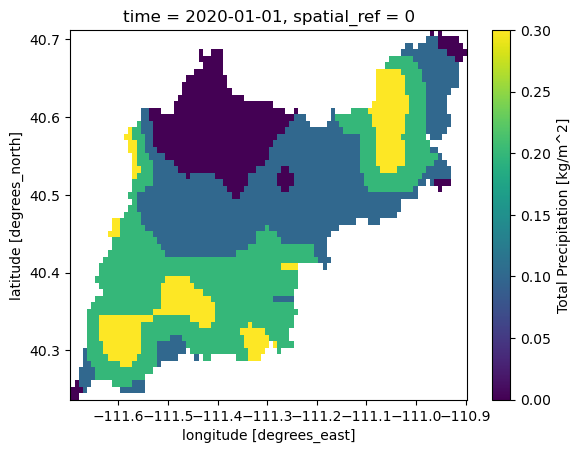

In [123]:
# plot the result for one timestep
_ = clipped.isel(time=0).APCP_surface.plot()

# OLD Code - Not Sure if we need this anymore

## Benchmark A: Subset data for one grid and calculate some stats

In [27]:
%%time
subset_1 = ds.isel(latitude=3000,longitude=1000)
subset_1

CPU times: user 3.08 ms, sys: 8 µs, total: 3.09 ms
Wall time: 3.11 ms


<xarray.Dataset>
Dimensions:              (time: 8784)
Coordinates:
    latitude             float64 45.0
    longitude            float64 -121.7
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    DLWRF_surface        (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    DSWRF_surface        (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    PRES_surface         (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    SPFH_2maboveground   (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    TMP_2maboveground    (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    UGRD_10maboveground  (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    VGRD_10maboveground  (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>

### Compute mean precipitation per day

In [29]:
%%time
subset_1_mean_daily_p = subset_1.APCP_surface.groupby('time.dayofyear').mean().compute()
subset_1_mean_daily_p

CPU times: user 708 ms, sys: 31.5 ms, total: 739 ms
Wall time: 1.36 s


<xarray.DataArray 'APCP_surface' (dayofyear: 366)>
array([1.1958333 , 0.02083333, 0.        , 0.17916667, 0.1875    ,
       0.375     , 0.        , 0.28333333, 0.18333334, 0.16666667,
       1.025     , 0.7291667 , 0.03333334, 0.475     , 0.10416666,
       0.08750001, 0.0625    , 0.25833336, 0.        , 0.        ,
       0.14583334, 0.3125    , 0.07083333, 0.32916668, 0.09583333,
       0.26250002, 0.14583333, 0.9791667 , 0.15833333, 0.11666667,
       0.05833333, 0.13333334, 0.30416667, 0.0125    , 0.        ,
       0.83750004, 0.25833336, 0.22083335, 0.625     , 0.00833333,
       0.        , 0.        , 0.        , 0.14166667, 0.13333334,
       0.1375    , 0.73333335, 0.0875    , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2875    , 0.075     ,
       0.        , 0.        , 0.        , 0.        , 0.5916667 ,
       0.        , 0.02083333, 0.10416666, 0.0125    , 0.        ,
       0.00833333, 0.1375    , 0.05      , 0.        , 0.        ,
       0.04583333, 0.        , 0.13333334, 0.26666668, 0.0375    ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.14583333, 0.025     , 0.37083337,
       0.        , 0.        , 0.06666667, 0.23750001, 0.79583335,
       1.0791667 , 0.02916667, 0.22916667, 0.025     , 0.        ,
       0.0375    , 0.        , 0.        , 0.        , 0.        ,
...
       0.04166667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2       , 0.95000005, 0.19166666,
       0.79583335, 0.81666666, 0.08750001, 0.025     , 0.0375    ,
       0.01666667, 0.00833333, 0.12083334, 0.        , 0.07916667,
       0.02916667, 0.0125    , 0.3125    , 0.00833333, 0.        ,
       0.        , 0.        , 0.        , 0.03333334, 0.02083333,
       0.        , 0.        , 0.025     , 0.02916667, 0.20416667,
       0.86666673, 0.04583333, 0.09166667, 0.00416667, 0.45833334,
       0.275     , 0.        , 1.0125    , 0.4375    , 1.3291668 ,
       0.16666667, 0.15      , 0.45416668, 0.42083335, 0.        ,
       0.        , 0.        , 0.10833334, 0.        , 0.35416666,
       0.09583333, 0.        , 0.        , 0.        , 0.47083333,
       0.02083333, 0.        , 0.        , 0.        , 0.        ,
       0.12916668, 0.        , 0.0875    , 0.        , 0.        ,
       0.07083333, 0.33333334, 0.30416667, 0.08750001, 0.10833333,
       0.21249999, 0.30833334, 0.00416667, 0.2       , 2.        ,
       0.16666667, 0.36666667, 0.        , 0.        , 0.1875    ,
       0.3375    , 0.00416667, 0.        , 0.        , 0.22500001,
       0.24166667], dtype=float32)
Coordinates:
    longitude  float64 -121.7
    latitude   float64 45.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    level:       surface
    long_name:   Total Precipitation
    short_name:  APCP_surface
    units:       kg/m^2

CPU times: user 14.8 ms, sys: 2.99 ms, total: 17.8 ms
Wall time: 18.5 ms


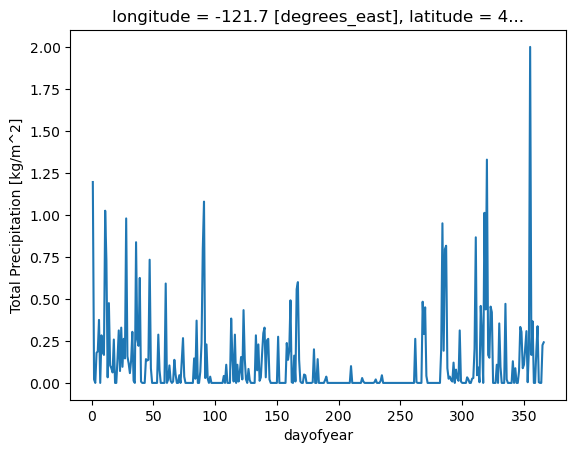

In [32]:
%%time
subset_1_mean_daily_p.plot()

### Compute monthly precipitation 

In [39]:
%%time
subset_1_monthly_p = subset_1.APCP_surface.groupby('time.month').sum().compute()
subset_1_monthly_p

CPU times: user 641 ms, sys: 28.4 ms, total: 669 ms
Wall time: 1.45 s


<xarray.DataArray 'APCP_surface' (month: 12)>
array([193.00002  , 110.1      ,  84.899994 ,  39.       ,  71.799995 ,
        68.1      ,   7.1000004,   2.9      ,  36.8      ,  89.9      ,
       168.       , 129.5      ], dtype=float32)
Coordinates:
    longitude  float64 -121.7
    latitude   float64 45.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    level:       surface
    long_name:   Total Precipitation
    short_name:  APCP_surface
    units:       kg/m^2

CPU times: user 17.1 ms, sys: 1.01 ms, total: 18.1 ms
Wall time: 17 ms


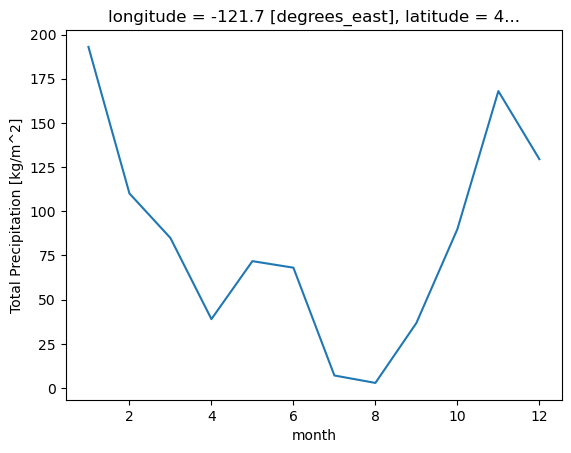

In [33]:
%%time
subset_1_monthly_p.plot()

### Compute annual precipitation 

In [37]:
%%time
subset_1_annual_p = subset_1.APCP_surface.groupby('time.year').sum().compute()
subset_1_annual_p

CPU times: user 596 ms, sys: 33.3 ms, total: 629 ms
Wall time: 1.66 s


<xarray.DataArray 'APCP_surface' (year: 1)>
array([1001.1001], dtype=float32)
Coordinates:
    longitude  float64 -121.7
    latitude   float64 45.0
  * year       (year) int64 2020
Attributes:
    level:       surface
    long_name:   Total Precipitation
    short_name:  APCP_surface
    units:       kg/m^2

<div class="alert alert-block alert-success">
<b> Note that the unit of precipitation is different from versio 1.0. Here it is total precipitation with the unit of kg/m2 that is mm. </b>

## Benchmark B: Subset data for a medium sized domain (e.g., a HUC12 region) and calculate some stats

In [53]:
%%time
# reduce to Provo River in Utah
subset_2 = ds.sel(latitude=slice(40.21, 40.71),longitude=slice(-111.7, -110.9))  
subset_2

CPU times: user 4.31 ms, sys: 0 ns, total: 4.31 ms
Wall time: 4.32 ms


<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 60, longitude: 96)
Coordinates:
  * latitude             (latitude) float64 40.22 40.22 40.23 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

### Compute mean precipitation per day averaged spatially across the domain

`groupby('timeofyear'),mean()` computes the daily mean values from hourly data. If we remove this part, we can see the time series of the hourly precipitaiton averaged spatially across the domain.

CPU times: user 1.41 s, sys: 53.1 ms, total: 1.46 s
Wall time: 2.02 s


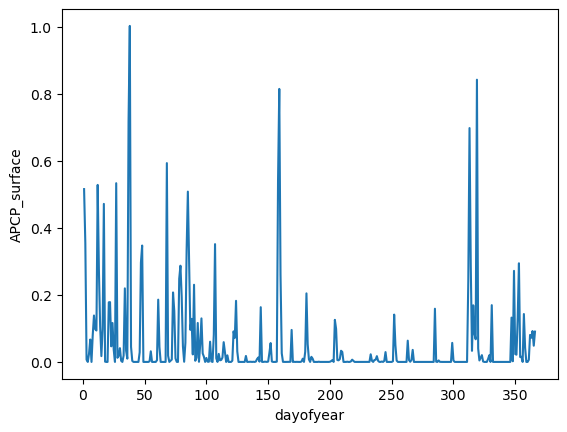

In [57]:
%%time
subset_2_mean_daily_p = subset_2.APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').mean().compute()
subset_2_mean_daily_p.plot()

### Compute annual precipitation averaged spatially across the domain

In [66]:
%%time
subset_2_annual_p = subset_2.APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.year').sum().compute()
subset_2_annual_p

CPU times: user 1.28 s, sys: 45.1 ms, total: 1.33 s
Wall time: 2.07 s


<xarray.DataArray 'APCP_surface' (year: 1)>
array([464.75464], dtype=float32)
Coordinates:
  * year     (year) int64 2020

### Prepare CFC forcing inputs 

In [70]:
# define the domain
wb_id='wb-2917533'

# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'{wb_id}/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')
gdf.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [71]:
# convert these data into the forcing data coordinate system
target_crs = 'EPSG:4326' 

gdf = gdf.to_crs(target_crs)

gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

This version of AORC data (version 1.1) has spatial metadata (latitude and longitude). So, we don't need to worry about adding the spatial metadata to the dataset as we did for version 1.0.

Add catchment ids to the geopandas. These will be used to perform zonal statistics later on.

In [110]:
%%time

# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

subset_2.rio.set_crs(target_crs, inplace=True)

for var_name in subset_2.data_vars:
    subset_2[var_name].attrs['crs']='EPSG:4326'
    
# clip AORC to the extent of the hydrofabric geometries
subset_2.rio.clip(gdf.geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False, from_disk=True)

# select a single array of data to use as a template
lwdown_data = subset_2.isel(time=0).DLWRF_surface

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=subset_2 # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
subset_2 = subset_2.assign_coords(cat = (['latitude','longitude'], out_grid.cat.data))

# compute the unique catchment IDs which will be used to compute zonal statistics
catchment_ids = np.unique(subset_2.cat.data[~np.isnan(subset_2.cat.data)])

print(f'The dataset contains {len(catchment_ids)} catchments')

The dataset contains 246 catchments
CPU times: user 430 ms, sys: 6.01 ms, total: 436 ms
Wall time: 467 ms


In [111]:
subset_2

<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 60, longitude: 96)
Coordinates:
  * latitude             (latitude) float64 40.22 40.22 40.23 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
    cat                  (latitude, longitude) float64 nan nan nan ... nan nan
Data variables:
    APCP_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 6, 96), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

Preview the gridded catchments over the watershed vector boundary.

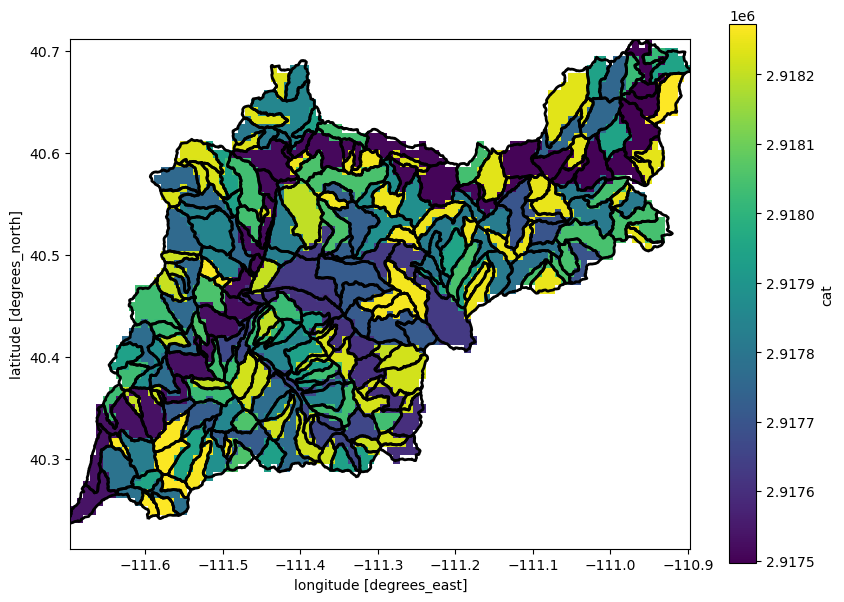

In [114]:
%%time

figure, ax = plt.subplots(figsize=(10,7))

# plot the gridded catchment mapping
subset_2.cat.plot()

# preview map geometries
gdf.iloc[:].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

Compute basin-averaged forcing data

In [130]:
# call once per catchment
# distribute zonal stats to sub processes
def perform_zonal_computation(ds):
   
    delayed = []
    # loop over variables   
    for variable in list(subset_2.data_vars):
                
        delay = dask.delayed(compute_zonal_mean)(ds_catchment[variable], variable)
        delayed.append(delay)
        
    res = dask.compute(*delayed)
    
    # combine outputs (list of dicts) into a single dict.
    res = {k: v for d in res for k, v in d.items()}
    
    # return results
    return {f'cat-{int(cat_id)}': res}

def compute_zonal_mean(ds, variable):
    return {variable: ds.groupby('cat').mean(dim=['x','y']).values}

#### Test zonal stat computation for a small period.

In [140]:
# isolate the desired time period of our data
ds_subset_2 = subset_2.sortby('time').sel(time=slice('2020-02-01', '2020-02-10'))

print(f'The dataset contains {len(ds_subset_2.time)} timesteps')

The dataset contains 240 timesteps


In [141]:
%%time
scattered_subset_2 = client.scatter(ds_subset_2, broadcast=True)

2023-10-04 01:30:37,296 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-10-04 01:30:38,918 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-10-04 01:30:40,640 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


CPU times: user 2.92 s, sys: 186 ms, total: 3.11 s
Wall time: 7.74 s


In [142]:
%%time
delayed = []
# loop over each catchment in our domain
# create delayed tasks to compute zonal mean
for cat_id in catchment_ids:
    delay = dask.delayed(perform_zonal_computation)(scattered_subset_2, cat_id)
    delayed.append(delay)

CPU times: user 12.2 ms, sys: 5 µs, total: 12.2 ms
Wall time: 11.8 ms


In [144]:
%%time 
# run the computation
results = dask.compute(*delayed)

## Benchmark C: Subset data for a large sized domain (e.g., a HUC2 region) and calculate some stats

In [63]:
%%time
# reduce to Great Basins
subset_3 = ds.sel(latitude=slice(36.048020187527, 41.8308079035245),longitude=slice(-121.32196958368947, -109.40336130407586))  
subset_3

CPU times: user 262 ms, sys: 2.02 ms, total: 264 ms
Wall time: 263 ms


<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 694, longitude: 1430)
Coordinates:
  * latitude             (latitude) float64 36.05 36.06 36.07 ... 41.82 41.82
  * longitude            (longitude) float64 -121.3 -121.3 ... -109.4 -109.4
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    DLWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    DSWRF_surface        (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    PRES_surface         (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    SPFH_2maboveground   (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    TMP_2maboveground    (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    UGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
    VGRD_10maboveground  (time, latitude, longitude) float32 dask.array<chunksize=(144, 122, 238), meta=np.ndarray>
Attributes:
    crs:      EPSG:4326

### Compute mean precipitation per day averaged spatially across the domain

CPU times: user 1min 16s, sys: 968 ms, total: 1min 17s
Wall time: 58.1 s


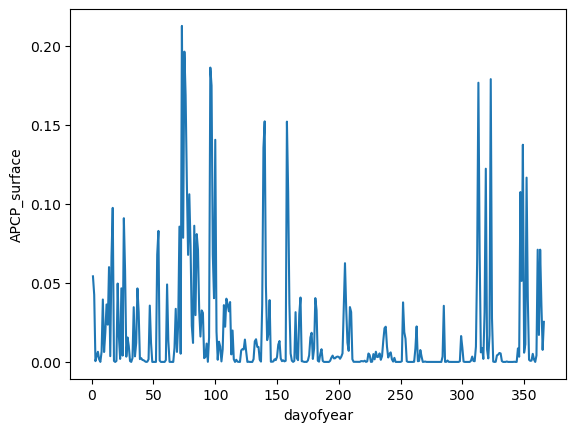

In [64]:
%%time
subset_3_mean_daily_p = subset_3.APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.dayofyear').mean().compute()
subset_3_mean_daily_p.plot()

### Compute annual precipitation averaged spatially across the domain

In [67]:
%%time
subset_3_annual_p = subset_3.APCP_surface.mean(dim=['latitude', 'longitude']).groupby('time.year').sum().compute()
subset_3_annual_p

CPU times: user 1min 16s, sys: 953 ms, total: 1min 16s
Wall time: 57.8 s


<xarray.DataArray 'APCP_surface' (year: 1)>
array([164.15588], dtype=float32)
Coordinates:
  * year     (year) int64 2020

## Conclusions

The computation time for each part:
    
- Dataset Overview
- Benchmark A: Subset data for one grid and calculate some stats
    - Compute mean precipitation per day,  **1.36 s**
    - Compute monthly precipitation, **1.45 s**
    - Compute annual precipitation, **1.66 s**
- Benchmark B: Subset data for a medium sized domain and calculate some stats
    - Compute mean precipitation per day averaged spatially across the domain, **2.02 s**
    - Compute annual precipitation averaged spatially across the domain, **2.07 s**
    - <font color='red'>Prepare CFC forcing inputs (this part may be improved if we use groupby, let's xarray.dev/blog/flox</font>
        - Test zonal stat computation for a small period, **7.74 s + ?**
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a large period. [TODO]</font>
- Benchmark C: Subset data for a large sized domain and calucalte some stats
    - Compute mean precipitation per day averaged spatially across the domain, **57.8 s**
    - Compute annual precipitation averaged spatially across the domain, **57.8 s**
    - <font color='red'>Prepare CFC forcing inputs [TODO]</font>
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a small period. [TODO]</font>
        - <font color='red'>Test zonal stat computation for a large period. [TODO]</font>